<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> MobileBERT </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> 
    
1. Input: This represents the 512-dimensional input to the MobileBERT model. It might be a token sequence or word embeddings.<br><br>

2. Embedding Layer: The input tokens are transferred via the Embedding Layer, which turns them into dense vector representations. The Embedding Layer is similarly 512 in size, matching the input dimension.<br><br>

3. Transformer Encoder Layers: This is MobileBERT's main component. It is made up of 24 Transformer Encoder Layers stacked in an inverted bottleneck configuration. On the input sequence, each layer conducts self-attention and feed-forward operations.<br><br>

- Inverted Bottleneck Structure: The arrangement of the 24 Transformer Encoder Layers is referred to as the inverted bottleneck structure. Its purpose is to minimise model size while preserving performance. The layers are built in such a way that the representation dimension gradually increases and then collapses, mimicking an inverted bottleneck form.<br><br>

4. Feed-Forward Networks (FFNs): There are stacked Feed-Forward Networks (FFNs) within each Transformer Encoder Layer. These networks process the self-attention mechanism's intermediate representations and apply non-linear changes to improve the model's expressive capability. The diagram includes two FFN layers, but depending on the implementation, there may be more.<br><br>

5. Pooler Layer: The output of the Transformer Encoder Layers is routed through the Pooler Layer. This layer handles pooling actions (for example, max-pooling). to summarize the information from the entire sequence into a fixed-size representation.<br><br>

6. Output: Finally, the pooled representation is supplied into the Output layer, which generates MobileBERT's final output. The output's specific nature is determined by the activity for which MobileBERT is employed, such as categorization or language production.<br><br>

The architecture of MobileBERT is intended to be a thin version of BERT_LARGE, with 24 layers instead of 512, and the internal representation dimension altered to strike a compromise between model size and performance. This enables MobileBERT to be more efficient and suited for deployment on low-resource devices while still attaining competitive performance on a variety of natural language processing applications.<br><br>
</div>

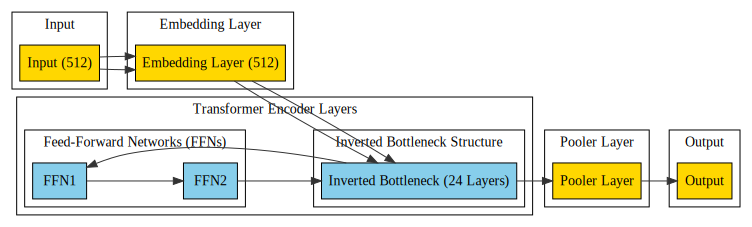

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/mobilebert/MobileBERT.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Importing modules
    </div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Saving the model and tokenizer for re-loading later </div>

In [3]:
# # Instantiate the tokenizer and model
# tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
# model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased',num_labels=30)

# # Cache the tokenizer and model to your local machine
# tokenizer.save_pretrained('/kaggle/working')
# model.save_pretrained('/kaggle/working')


In [4]:
# Load the tokenizer and model from your local cache
tokenizer = MobileBertTokenizer.from_pretrained('/kaggle/input/mobilebert')
model = MobileBertForSequenceClassification.from_pretrained('/kaggle/input/mobilebert', num_labels=30)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Reading the dataframes </div>

In [5]:
train_df = pd.read_csv('/kaggle/input/google-quest-challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Checking the columns of train and test df </div>

In [6]:
train_df.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [7]:
test_df.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host'],
      dtype='object')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining custom dataset class </div>

In [8]:
class QADataset(Dataset):
    def __init__(self, texts, tokenizer,mode="Train",labels=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.mode = mode
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.mode=="Train":
            label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        if self.mode=="Test":
            return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
            
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }
        

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Creating train texts and labels for training </div>

In [9]:

train_texts = train_df['question_title'] + ' ' + train_df['question_body'] + ' ' + train_df['answer']
train_labels = train_df.iloc[:, 11:]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Splitting into training and validation sets </div>

In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    random_state=42
)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Creating dataset </div>

In [11]:
train_dataset = QADataset(train_texts.tolist(),tokenizer,mode="Train", labels=train_labels.values)
val_dataset = QADataset(val_texts.tolist(), tokenizer,mode="Train",labels= val_labels.values)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining batch size and num epochs </div>

In [12]:
batch_size = 8
num_epochs = 10


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining the train and val loaders </div>

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Setting the device and moving the model to device </div>

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining the optimizer and loss function </div>

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Performing sanity check of the train dataloader </div>

In [16]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[  101,  4022, 25718,  ...,     0,     0,     0],
        [  101,  2129,  2000,  ...,  2069,  2004,   102],
        [  101,  2073,  2001,  ...,     0,     0,     0],
        ...,
        [  101, 25081,  2104,  ...,     0,     0,     0],
        [  101,  2339,  2515,  ...,     0,     0,     0],
        [  101,  3443,  9398,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[1.0000, 0.3333, 0.3333, 1.0000, 1.0000, 0.5000, 0.5556, 0.4444, 0.0000,
         0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.6667, 0.8889, 0.6667, 0.8889, 1.0000, 0.9333, 0.0000,
         0.0000, 1.0000, 0.7778],
        [1.0000, 1.0000, 0.0000, 0.3333, 1.0000, 1.0000, 0.6667, 0.7778, 0.0000,
         0.0000, 0

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Checking the number of steps per epoch </div>

In [17]:
len(train_dataloader),len(val_dataloader)

(608, 152)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Training the model </div>

In [18]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for step, batch in tqdm(enumerate(train_dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        if step%100==0:
            print("Step-{},Loss-{}".format(step,loss.item()))
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
    
    # Validation
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Validation Loss: {avg_val_loss}')

1it [00:02,  2.10s/it]

Step-0,Loss-3362094.459560185


101it [00:39,  2.68it/s]

Step-100,Loss-33.69345577404807


201it [01:15,  2.65it/s]

Step-200,Loss-10.6375881678224


301it [01:52,  2.88it/s]

Step-300,Loss-1.2305660220229044


401it [02:28,  2.58it/s]

Step-400,Loss-1.0069733729923394


501it [03:04,  2.88it/s]

Step-500,Loss-0.9065624776635216


601it [03:40,  2.85it/s]

Step-600,Loss-0.8241211687956281


608it [03:42,  2.73it/s]


Epoch 1/10, Loss: 52053.872138154715
Validation Loss: 14.772195683964203


1it [00:00,  2.76it/s]

Step-0,Loss-0.7834524495636664


101it [00:36,  2.67it/s]

Step-100,Loss-0.6742921656133882


201it [01:13,  2.89it/s]

Step-200,Loss-33.93309425273458


301it [01:49,  2.84it/s]

Step-300,Loss-38.46864387704322


401it [02:25,  2.90it/s]

Step-400,Loss-0.5041369775501167


501it [03:01,  2.80it/s]

Step-500,Loss-0.48797769028158794


601it [03:37,  2.79it/s]

Step-600,Loss-0.5165363903044016


608it [03:40,  2.76it/s]


Epoch 2/10, Loss: 5.907780614466032
Validation Loss: 4.2154875681639705


1it [00:00,  2.99it/s]

Step-0,Loss-0.43461215079011806


101it [00:37,  2.79it/s]

Step-100,Loss-0.49319845217293024


201it [01:13,  2.89it/s]

Step-200,Loss-0.4589844835774015


301it [01:49,  2.68it/s]

Step-300,Loss-0.4735536767227394


401it [02:25,  2.89it/s]

Step-400,Loss-0.4434456498687871


501it [03:01,  2.81it/s]

Step-500,Loss-0.4089080541278128


601it [03:37,  2.92it/s]

Step-600,Loss-0.5023948646266244


608it [03:39,  2.77it/s]


Epoch 3/10, Loss: 1.2747685995208258
Validation Loss: 2.09589028090342


1it [00:00,  2.50it/s]

Step-0,Loss-0.43084080960983157


101it [00:37,  2.94it/s]

Step-100,Loss-0.4802970802455335


201it [01:13,  2.56it/s]

Step-200,Loss-0.44331933026043574


301it [01:49,  2.83it/s]

Step-300,Loss-48.96481824416302


401it [02:24,  2.77it/s]

Step-400,Loss-0.5221288621841341


501it [03:00,  2.83it/s]

Step-500,Loss-0.4691737446780543


601it [03:36,  2.83it/s]

Step-600,Loss-0.4535426800105833


608it [03:38,  2.78it/s]


Epoch 4/10, Loss: 1.0445517306559962
Validation Loss: 1.026870458059057


1it [00:00,  3.13it/s]

Step-0,Loss-0.4483680996690129


101it [00:36,  2.83it/s]

Step-100,Loss-0.4885737335621363


201it [01:12,  2.73it/s]

Step-200,Loss-0.3708848577814044


301it [01:48,  2.89it/s]

Step-300,Loss-0.4542896023016194


401it [02:23,  2.70it/s]

Step-400,Loss-0.42589449719553596


501it [02:59,  2.69it/s]

Step-500,Loss-0.5182454722502263


601it [03:35,  2.74it/s]

Step-600,Loss-0.4324467881589522


608it [03:37,  2.79it/s]


Epoch 5/10, Loss: 0.9364368036487968
Validation Loss: 0.47103088399383697


1it [00:00,  2.99it/s]

Step-0,Loss-0.418630412313916


101it [00:36,  2.86it/s]

Step-100,Loss-0.4408616268173082


201it [01:12,  2.80it/s]

Step-200,Loss-0.40901848865556534


301it [01:47,  2.91it/s]

Step-300,Loss-0.42695256222145905


401it [02:23,  2.74it/s]

Step-400,Loss-0.4427453169995638


501it [02:59,  2.70it/s]

Step-500,Loss-0.4190250631672151


601it [03:35,  2.80it/s]

Step-600,Loss-0.4379872174187417


608it [03:38,  2.78it/s]


Epoch 6/10, Loss: 21.46493694555579
Validation Loss: 0.4351223749020878


1it [00:00,  2.44it/s]

Step-0,Loss-0.38628833508812427


101it [00:36,  2.68it/s]

Step-100,Loss-0.4470720883850501


201it [01:12,  2.77it/s]

Step-200,Loss-0.3794273826994845


301it [01:48,  2.63it/s]

Step-300,Loss-0.437924356507353


401it [02:24,  2.85it/s]

Step-400,Loss-0.4350894724696565


501it [02:59,  2.92it/s]

Step-500,Loss-0.4337772678026603


601it [03:35,  2.89it/s]

Step-600,Loss-0.4693892160402115


608it [03:38,  2.79it/s]


Epoch 7/10, Loss: 0.43479231313601735
Validation Loss: 0.4323853396829636


1it [00:00,  2.75it/s]

Step-0,Loss-0.49269236865638844


101it [00:36,  2.66it/s]

Step-100,Loss-0.45976743797821684


201it [01:12,  2.76it/s]

Step-200,Loss-0.4505307964188924


301it [01:48,  2.60it/s]

Step-300,Loss-0.43359371420184595


401it [02:24,  2.70it/s]

Step-400,Loss-0.44605686085311486


501it [03:00,  2.87it/s]

Step-500,Loss-0.41166189391264596


601it [03:35,  2.92it/s]

Step-600,Loss-0.44749812103155256


608it [03:38,  2.79it/s]


Epoch 8/10, Loss: 0.4323503954117528
Validation Loss: 0.42990914045962114


1it [00:00,  2.85it/s]

Step-0,Loss-0.44905088823653394


101it [00:36,  2.75it/s]

Step-100,Loss-0.4379208134685164


201it [01:12,  2.77it/s]

Step-200,Loss-0.48754241616981203


301it [01:48,  2.91it/s]

Step-300,Loss-0.38388012163358154


401it [02:24,  2.75it/s]

Step-400,Loss-0.445685659892554


501it [02:59,  2.92it/s]

Step-500,Loss-0.46837148167220355


601it [03:35,  2.78it/s]

Step-600,Loss-0.4904954288169837


608it [03:38,  2.79it/s]


Epoch 9/10, Loss: 0.42986050238204143
Validation Loss: 0.4284029771516826


1it [00:00,  2.68it/s]

Step-0,Loss-0.40917511497294556


101it [00:37,  2.40it/s]

Step-100,Loss-0.4391302320089919


201it [01:12,  2.77it/s]

Step-200,Loss-0.42295106309604275


301it [01:48,  2.82it/s]

Step-300,Loss-0.42651041349393226


401it [02:24,  2.90it/s]

Step-400,Loss-0.3887273885400574


501it [03:00,  2.80it/s]

Step-500,Loss-0.3682196360182112


601it [03:37,  2.85it/s]

Step-600,Loss-0.4669545429459972


608it [03:39,  2.77it/s]


Epoch 10/10, Loss: 0.42835722713717916
Validation Loss: 0.4271932053128618


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Creating train texts </div>

In [19]:
# Combine the question and answer texts for testing
test_texts = test_df['question_title'] + ' ' + test_df['question_body'] + ' ' + test_df['answer']

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    loading the tokenizer </div>

In [20]:
test_dataset = QADataset(test_texts.tolist(), tokenizer, mode="Test")


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Defining batch size and dataloader for test set </div>

In [21]:
batch_size = 8

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Performing sanity check of the dataloader </div>

In [22]:
for batch in test_dataloader:
    print(batch)
    break

{'input_ids': tensor([[  101,  2097,  2975,  ...,     0,     0,     0],
        [  101, 24471,  2140,  ...,     0,     0,     0],
        [  101,  2003, 10640,  ...,     0,     0,     0],
        ...,
        [  101,  3599,  2129,  ...,     0,     0,     0],
        [  101,  9530,  8873,  ...,  2022,  5068,   102],
        [  101,  2339,  2360,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Generating predictions </div>

In [23]:
model.eval()
model.to(device)
predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Apply sigmoid activation to convert logits to probabilities
        probabilities = torch.sigmoid(logits)
        
        # Append the probabilities to the predictions list
        predictions.append(probabilities.detach().cpu().numpy())
    

100%|██████████| 60/60 [00:10<00:00,  5.99it/s]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Generating submission </div>

In [24]:
# Concatenate the predictions from multiple batches
predictions = np.concatenate(predictions)
# Create a DataFrame for the submission file
submission_df = pd.DataFrame(predictions, columns=train_df.columns[11:])
submission_df.insert(0, 'qa_id', test_df['qa_id'])

# Save the submission file
submission_df.to_csv('submission.csv', index=False, float_format='%.6f')


In [25]:
submission_df

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.870615,0.573468,0.069259,0.720707,0.723637,0.742527,0.840545,0.546499,0.183518,...,0.927567,0.919456,0.734087,0.936989,0.968663,0.735645,0.208977,0.197058,0.537305,0.903201
1,46,0.845006,0.511829,0.044824,0.739275,0.765682,0.814950,0.707765,0.486531,0.097087,...,0.835540,0.872437,0.682513,0.948103,0.982129,0.876212,0.682497,0.205851,0.201307,0.935099
2,70,0.911381,0.791037,0.039504,0.917522,0.814673,0.627874,0.595965,0.614238,0.505424,...,0.826478,0.940760,0.694538,0.976739,0.972976,0.874560,0.459345,0.070560,0.567622,0.850125
3,132,0.858099,0.544629,0.042124,0.580980,0.800564,0.845020,0.517074,0.431164,0.403949,...,0.785153,0.946136,0.656469,0.955076,0.963581,0.615057,0.504857,0.296519,0.500510,0.895737
4,200,0.782949,0.487207,0.052834,0.573099,0.714412,0.775226,0.707194,0.702011,0.281686,...,0.855692,0.947688,0.727051,0.929366,0.961163,0.540924,0.143241,0.195146,0.558673,0.871724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,9569,0.806210,0.459952,0.092608,0.626685,0.783732,0.825043,0.556185,0.516255,0.148821,...,0.724008,0.920363,0.681870,0.894746,0.942731,0.833920,0.608634,0.095704,0.457749,0.830477
472,9590,0.754014,0.313052,0.009161,0.735268,0.772561,0.917004,0.594177,0.339694,0.197627,...,0.747171,0.965442,0.606469,0.952816,0.978001,0.888002,0.856456,0.262908,0.284222,0.975316
473,9597,0.908857,0.583960,0.052261,0.611765,0.715374,0.837003,0.629163,0.474146,0.197706,...,0.782750,0.889394,0.700846,0.932147,0.979403,0.868431,0.559343,0.112223,0.365423,0.860712
474,9623,0.896441,0.784940,0.061609,0.880021,0.875479,0.614889,0.512765,0.352680,0.231918,...,0.812295,0.930355,0.672897,0.969578,0.976254,0.940048,0.342601,0.093753,0.820381,0.895607
